<a href="https://colab.research.google.com/github/pmj-chosim/Commit-Project-2023.1.20-2023.2.28-/blob/main/2023.02.08/1_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd content/drive/MyDrive/2023-02-08/2023W_CV_BootCamp

[Errno 2] No such file or directory: 'content/drive/MyDrive/2023-02-08/2023W_CV_BootCamp'
/content


#Cifar 10 데이터셋 - #1


In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

#데이터 변형 옵션을 위해 미리 설정값을 셋업해둠
transform_train = transforms.Compose([
    
    # 데이터 어그맨테이션역할을 수행하는 RandoeCrop, RnadomHorizontalFilp함수 추가
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#torchvision 패키지로부터 미리 설정해둔 값으로 변경해서 받아옴
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True)


testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#Data augmentation 예제 - #2

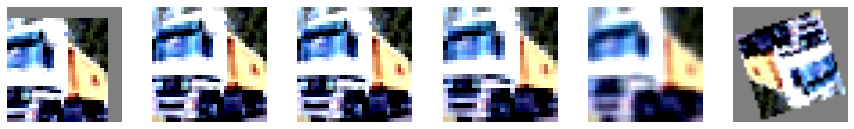

In [6]:
import torchvision.transforms
from matplotlib import pyplot as plt
import numpy as np

image ,label = trainset[1]

crop = transforms.RandomCrop(32, padding= 4) #이미지 확대
horflip = transforms.RandomHorizontalFlip() #수직선기준 뒤집기
verflip = transforms.RandomVerticalFlip()  #수평기준 ,,
resize = transforms.Resize((24,24)) 
gaussian = transforms.GaussianBlur(kernel_size = (3,3), sigma = (0.1,5)) #가우시안 노이즈 추가
rotate = transforms.RandomRotation(180, expand = True)

augmentation = [crop,horflip,verflip,resize,gaussian,rotate]

plt.figure(figsize = (12,12))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

for i, transform in enumerate(augmentation,start=1):
  transformed_sample = transform(image)
  plt.subplot(6,6,i)
  imshow(transformed_sample)
  plt.tight_layout()
  plt.axis('off')
plt.show()

#Data augmentation 예제 - #3

torch.Size([4, 220, 220])
<class 'torch.Tensor'>


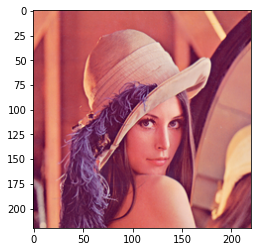

In [9]:
import cv2
import torch
from PIL import Image

img = Image.open('/content/drive/MyDrive/2023-02-08/2023W_CV_BootCamp/3차시/images/Lenna.png')

tf = transforms.ToTensor()
sample_image = tf(img)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(sample_image)

print(sample_image.shape)
print(type(sample_image))

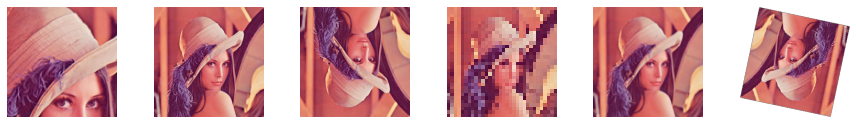

In [10]:
plt.figure(figsize = (12,12))

crop = transforms.RandomCrop(100, padding= 4)
horflip = transforms.RandomHorizontalFlip()
verflip = transforms.RandomVerticalFlip()
resize = transforms.Resize((32,32))
gaussian = transforms.GaussianBlur(kernel_size = (3,3), sigma = (0.1,5))
rotate = transforms.RandomRotation(180, expand = True)

augmentation = [crop,horflip,verflip,resize,gaussian,rotate]

for i, transform in enumerate(augmentation,start=1):
  transformed_sample = transform(sample_image)
  plt.subplot(6,6,i)
  imshow(transformed_sample)
  plt.tight_layout()
  plt.axis('off')
plt.show()


#Cutmix - #4


In [11]:
import numpy as np
import random
from torch.utils.data.dataset import Dataset

#정답 레이블 원핫 벡터 생성
def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec

#베타분포로부터 0<x<1 값이 lam에 할당됨
def rand_bbox(size, lam):
    #이미지에 배치사이즈가 포함되어 있을 시 WxH
    if len(size) == 4:
        W = size[2]
        H = size[3]
    #이미지에 배치사이즈가 포함되어 있지 않을 시 WxH
    elif len(size) == 3:
        W = size[1]
        H = size[2]
    else:
        raise Exception
    
    #1에서 0<x<1 의 확률을 빼고 제곱근 값이 이미지 생성 비율에 사용됨.
    cut_rat = np.sqrt(1. - lam) # 패치 크기의 비율 정하는곳
    
    #만약 cut_rat이 0.9이면 패치의 높이는 3.2가됨.
    cut_w = np.int(W * cut_rat) # 패치의 넓이
    cut_h = np.int(H * cut_rat) # 패치의 높이

    # 기존 이미지의 크기에서 랜덤하게 값을 가져옴.(중간 좌표 추출)
    # 패치를 붙일 중간 포인트값을 랜덤하게 가져옴.
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # 패치 부분에 대한 좌표값 추출 -가 나올수도 있고 오버값이 나올수도있어서
    # 하한값 상한값을 설정해줌.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [13]:
class CutMix(Dataset):
    def __init__(self, dataset, num_class, num_mix=1, beta=1., prob=1.0):
        self.dataset = dataset
        self.num_class = num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob

    def __getitem__(self, index):
        #차례대로 인덱스 올건데 이미지 레이블 받아옴
        img, lb = self.dataset[index]
        #label의 원핫 벡터를 보여줌. 
        lb_onehot = onehot(self.num_class, lb)

        for _ in range(self.num_mix):
            #랜덤 값 하나 생성
            r = np.random.rand(1)
            # 컷믹스를 할지 안할지 판단하는 논리연산자.
            # 조건을 만족하면 다시 반복문으로 돌아가고, 만족못할시에 코드를 지속한다. 
            if self.beta <= 0 or r > self.prob:
                continue
            # generate mixed sample
            # 베타분포 : 확률을 위한 확률 분포. 1,1은 uniform 분포고, 아무값이나 될 수 있음. (0<x<1)
            # 모든확률이 될 확률이 동일하다는 말임.
            lam = np.random.beta(self.beta, self.beta)

            #랜덤한 인덱스 값 생성
            rand_index = random.choice(range(len(self)))

            #cutmix할 이미지를 데이터셋에서 임의로 가져옴
            img2, lb2 = self.dataset[rand_index]
            #새로운 이미지의 레이블 원핫 벡터 생성
            lb2_onehot = onehot(self.num_class, lb2)

            #랜덤한 4개의 패치 포인트 할당
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            #이미지 1에다가 이미지 2패치를 바꿔 끼워줌
            img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]

            #비율이 일치하도록 람다를 조정
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            #ex) x1 = 30, x2 = 70, y1 = 20, y2 = 50, w = 100, h = 200
            #위 식에 예로 설정한 값을 넣으면 각 레이블에 비율이 60, 40이나옴
            #결론적으로 정답레이블이 해당 비율로 산정됨
            lb_onehot = lb_onehot * lam + lb2_onehot * (1. - lam)
        return img, lb_onehot
    def __len__(self):
        return len(self.dataset)


<ipython-input-11-64b9b6d070d9>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat) # 패치의 넓이
<ipython-input-11-64b9b6d070d9>:28: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; f

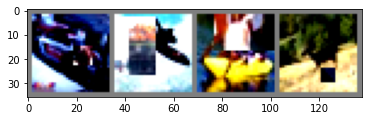

In [25]:
dataset = CutMix(trainset, num_class=10, beta=1.0, prob=1.0, num_mix=1) 

trainloader_cutmix = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2)

loader_cutmix = iter(trainloader_cutmix)
images_cutmix, labels_cutmix = next(loader_cutmix)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images_cutmix))
